In [19]:
# Jupyter notebook template for IEEE papers
#
# by Mandar Chitre
# 12 June 2018

In [20]:
# Title, author and affiliation are added to the notebook metadata
# (accessed through "Edit Notebook Metadata" menu item).
#
# The bibliography (if any) is also specified in the metadata (without the .bib extension).
#
# The entries look something like this:
#
# "latex_metadata": {
#    "title": "Title of the article",
#    "author": "John Doe,~\\IEEEmembership{Member, IEEE}",
#    "affiliation": "Some Organization",
#    "bibliography": "references",
#    "options": "journal,onecolumn",        // omitting this entry defaults to "journal,twocolumn"
#    "packages": "\\usepackage{algorithm}"  // add optional packages
# }

#TODO write some sentence about general motivation for bibliometric analysis
We explore ways to extract information from ICLS and CSCL papers to gain an understanding about the community formed by conference participants and what research is being conducted within the community. After describing how to extract data from the original dataset in suitable format for analysis we perform an exploratory data analysis after which we derive insights into the community using social network analysis and [Nour: NLP etc].
#TODO write a few centences about the most central findings

# Introduction

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

# Data Processing

As a starting point we have papers of 4 years spanning 2015 to 2018 of the proceedings of ICLS, which is held in even years, respectively CSCL, held in odd years.  The overall number of papers per year is shown in figure  $\ref{fig1}$. The provided raw dataset consists of papers in pdf format as well as associated metadata in xml format. To extract information from the dataset we first need to convert the data a format that is more adapt to the task of data exploration and handling with a variety of external libraries. 
We store the data we extract from the provided dataset in csv format, as this makes it accessible to any scientist and is unlikely to become an obsolete any time soon. 

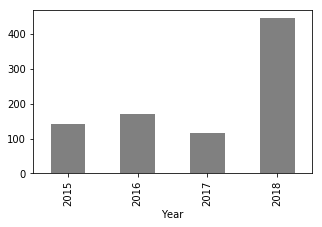

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

metadata = pd.read_csv('../data/Parsed_metadata.csv', index_col=0, parse_dates=['accessioned', 'available', 'issued'])
metadata['issued'] = metadata.issued.map(lambda x: x.year)

plt.figure(figsize=(5, 3))
plt.xlabel('Year')
metadata[~metadata.file.duplicated()].issued.value_counts().sort_index().plot(kind='bar', color='grey')
plt.show()

## Processing the Metadata

We extract the xml metadata  into a csv file containing the information associated to different tags in its columns using the _lxmltree_ python library. 
The provided xml does not exactly follow the xml standard, hence we handle errors by iteratively parsing the xml tree. We then add columns that reference the name of the source file and the order in which an author name occurs in the xml file. From the associated citation string we add in a shortened version of author names, and the “author names (year) title” string that we later use to identify a paper. 
Having extracted the metadata we then clean it by unifying names as slight spelling differences exist within the same author name. This is done by splitting up names based on whitespace and commas. If the intersection of the set of substrings of two distinct names contains at least 2 names of length at least 3 we consider these two names to be identical. Using this we reduce the number of authors in the dataset from 1951 down to 1879. 
To unify the names further, we need to make sure to not overmerge by labeling to different authors as having the same name. We do this by constructing the graph of co-authorship and then only considering names of authors that are in the same neighborhood of a node on the graph. Then we use the difflib library to check for similarity of two names and merge them if they reach a the threshold of 0.8. This method again reduces the number of authors in the dataset from 1879 to 1951. 

## Handling of pdf data

To extract information from the papers themselves we need to first extract the text from the pdfs. Various parsers performing this task exist. However, many parsers [pdfminer, PyPDF2] claiming to be able to extract the text as well as metadata from papers have not been kept up to date, which leads to issues with dependencies. We found that the most reliable parser is poppler https://poppler.freedesktop.org/. We note that due to inconsistencies with numbering, some of the pdfs were not extracted correctly from the proceedings which leads to text files that are either empty or do not contain the text of the paper referenced in the metadata. 

The advantage of papers is that they are structured fairly regularly. From ISLS Guildines \ref{ISLS_Author_Guidelines_Oct2014.pdf} we know papers the papers in our dataset should be structured. We use this to our advantage in the following sections when extracting information from the paper text.


## Extracting the papers cited by a paper

We know that each valid paper should contain a reference section at the end listing all the references cited in the paper. While there are tools being developed to extract the reference section directly from pdfs, notably [scholarcy], we found that none of them produced satisfactory results as of the time writing this report. Hence we resort the using regular expressions and our knowledge about how references should be presented within the paper.

To get the reference section we use a regular expression to find the ‘Reference’ header and cut of at the end if an Acknowledgement or Appendix section is present. Python has two modules that implement regular expressions _re_ and _regex_. We used regex as it allows to better handle unicode strings by having unicode expressions. This is important as many authors have names that do contain non-ascii characters. To get the individual reference we tested many ways to split up the lines, but ultimately, the most robust way was to split up the section at each new line and the glue the references back together if the lines satisfy a set of conditions.  
- The underlying idea is that APA references, the standard referencing format, all have the same initial structure: Authors (year) title, other identifying information. We thus check that the beginning of each reference contains “Authors (year)”. It is relatively easy to check for this using regular expressions as Author names and year have a given structure. If a string does not contain such a section, then it must be part of an other reference, which is lies before in the list of reference substrings. 

Consider that the references strings are structured the following way [...., reference_part_i, reference_part_i+1, ….]
Algorithm:

$$
1. Merge names that were cut up. We detect them by checking against the regular expression: __ 
2. Check ending for invalid sentence endings:  reference_part_i ends in comma, :, whitespace uppercase followed by point. If condition holds reference_part_i+1
3. Check beginning for invalid reference starts: not starting in a letter. Merge with reference_part_i if condition holds.
4. Check if a  invalid reference_part_i+1 consists only of the authors names. If so Merge with reference_part_i
5. Move up all sentences that do not contain author names / start of a citation at the beginning 
6. Move up all sentences that do not have a valid citation start
$$
After this we validate the returned split by looking at the overall length and the initials, as well as checking that a random sample returns satisfactory splitting accuracy. We find that the above method of extracting the references produces good results for proper APA citations and on APA citations outperforms Scolarcy. 


## Extracting Institution and Location
Now we consider the information present in the section before the abstract, which contains the authors names, their email and the institution they are affiliated with. Affiliation with institution can give us a lot of insight where people are working and gives use a way estimate where they are from. To go from this section to an exact affiliation with an institution a multifaceted approach was used.  

### Approach 1
The most robust way to get a persons institution affiliation is to use their email. Emails can easily be extracted from the header section using a regular expression and given a domain-university mapping [] give us an onto mapping from domain to institution. The additional advantage of this method is that using the additional metadata associated to each university in the mapping, we also access information about the country of the university. 

### Approach 2
The header section itself contains information on the institution, but as different was to list authors are accepted, notably two ways [fig _ a and b]. Hence, we first detect the structure of the header section before extracting the association. We tag the substring present in this section using a combination of named entity detection, using the implementation provided by spacy, simple matching of the names of authors and institutions we extracted from the metadata respectively from Approach 1 and tagging sections containing “emails” using regex , to detect where in the header the email is. Then, taking the tagged section, we detect which subsections correspond to which author-affiliation listing type, and extract the author email - institution mapping accordingly. 

Approach 2 allows to match many more institutions to authors than Approach 1 as not every institution is present in the mapping and many participants use gmail and similar providers as their official correspondence email we are unable to acquire this information for many participants. But, Approach 2 may contain differences in spelling in the institution name, which need to be merged. Thus we combine both approaches, and use the corresponding institutions in Approach 1 to unify the institutions obtained in Approach 2.  As institution affiliation does not allow us to automatically associate a country to the institution, we need to get this through additional means. A first step is to use the top level domains present in the emails to associate a country of origin to the participants & their associated institutions. Alongside this, to plot the community we augment the dataset with geolocation information, having this information we can then easily associate a country to the institution.

As there are a variety of way in which the name of an institution could be written –consider EPFL, EPF Lausanne– it was found that crawling the english, french and german version of Wikipedia  (not using the API, or the API wrapper, as this does not give access to the desired information) and using _BeautifulSoup_ the get the coordinates present in the article was a quick and accurate way to get the location as the website directs to the relevant article on the institution even when misspellings are present. But not all institutions, even well known ones such as Tokyo University, have their coordinates listed on their Wikipedia. 
To get the remaining locations we use the geopy, which is a client for geocoding web services. These results however are more error prone and will always return a result.
Then, to get the country we can then again use geopy. The resulting data containing paper identifier, the authors email, it’s associated domain, order in which the author was cited, the institution, country, Longitude and Latitude  are saved to csv. We use the paper identifier and author order to associate this data with the metadata to link information about authors with the papers they authored.

## Keywords extraction 

### Text preprocessing

From the pdf parser some of the documents were corrupted with some weird caracters such as , white space strings

* We used ***beautiful soup*** and ***string*** libraries to only keep the text that we needed without any special character. 

* we applied ***regular expression*** to remove numbers because we thought that numbers were not that important. 

* We put all the words to lower cases 

* We removed the words that were connecting parts of a sentence rather than showing subjects, objects or intent. For us these words were not that important and were only going to increase the bag of words length

* In some methods we used ***Lemmatization*** and ***stemming*** and in other methods we didn't because we wanted to do a mapping with ***GloVe*** vocabulary which we will explain later on. 

***Lemmatization*** is a word variations to the root of the word (e.g. working, works, worked changed to work).
***Stemming*** is the process of reducing inflected and derived words to their word stem, base or root form—generally a written word form
As the use of the stop words to reduce the BOW (bag of words size we also used lemmatization and stemming to be able to reduce the number of words without taking off any information)


***Lemmatization*** and different form of ***Stemming*** were only used with ***TF-IDF*** while doing the Keywords extraction, otherwise we prefered keeping the words as they are because we were doing a mapping with a pretrained stanford word embedding and we did not wand to loose interpretability.  


For the Keywords extraction we used three methods. 
The first one whe is a trivial one is to search in the pdf itself for keywords and extract them, this method is the most accurate but we found out that for 492 papers we had no keywords included. So we deciced to use two methods for keywords extraction. The first one is ***TF-IDF*** and the second one is ***Rake***.

* ***TF-IDF***:
Tf–idf is one of the most popular term-weighting schemes today, in information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. 



With TF-IDF we sorted for each document the words with the highest score and then selected the the 7 first words for each document. 

* ***Rake***: Rake stands for  Rapid Automatic Keyword Extraction. It is an existing python implementation that uses the NLTK toolkit for the score calculations. 

***How it works*** : 
  * It splits the text into sentences and generates some words as candidates.  
  * Various punctuation signs will be treated as sentence boundaries.
  * All words listed in the stopwords file will be treated as phrase boundaries. This helps generate candidates that consist of one or more non-stopwords. However ,it won’t work in cases where the stopword is part of the phrase. For example, ‘new’ is listed in RAKE’s stopword list. This means that neither ‘New York’ nor ‘New Zealand’ can be ever a keyword.
  * For each keyword candidate generated, the algorithm computes the score of the pretended keyword, which is the sum of the scores for each of its words (if it's a composed word). The words are scored according to their frequency and the typical length of a candidate phrase in which they appear.
  * The last step is ranking the scores ansd selecting the ones with the highest score

***Keywords in text***: Select from the text the keywords already given by the authors of the paper. 

Once we have all the keywords from the three methods, we tried to select the most accurate keywords. So we created a method that selects the intersection of TF-IDF keywords and the Rake keywords with the keywords of the authors (if there are any keywords in the text), if the intersection is empty and we have the keywords in the text we only take the keywords of the text. If we don't have any keywords we take the intersection of the TF-IDF and the Rake. If again, the intersection is empty then we only take the TF-IDF keywords because they were closer to the text keywords than the Rake Keywords. 


Once we have our final keywords, we created a method that goes into the metadata and put assign to every document a publication year. 

In [4]:
keywords_df = pd.read_csv('../keywords_final.csv')

Since we don't have the same number of documents for each year we needed to scale over the years and use the percentage of appearence of a word. 
So after groupping the words by year and scaling them we found graph below

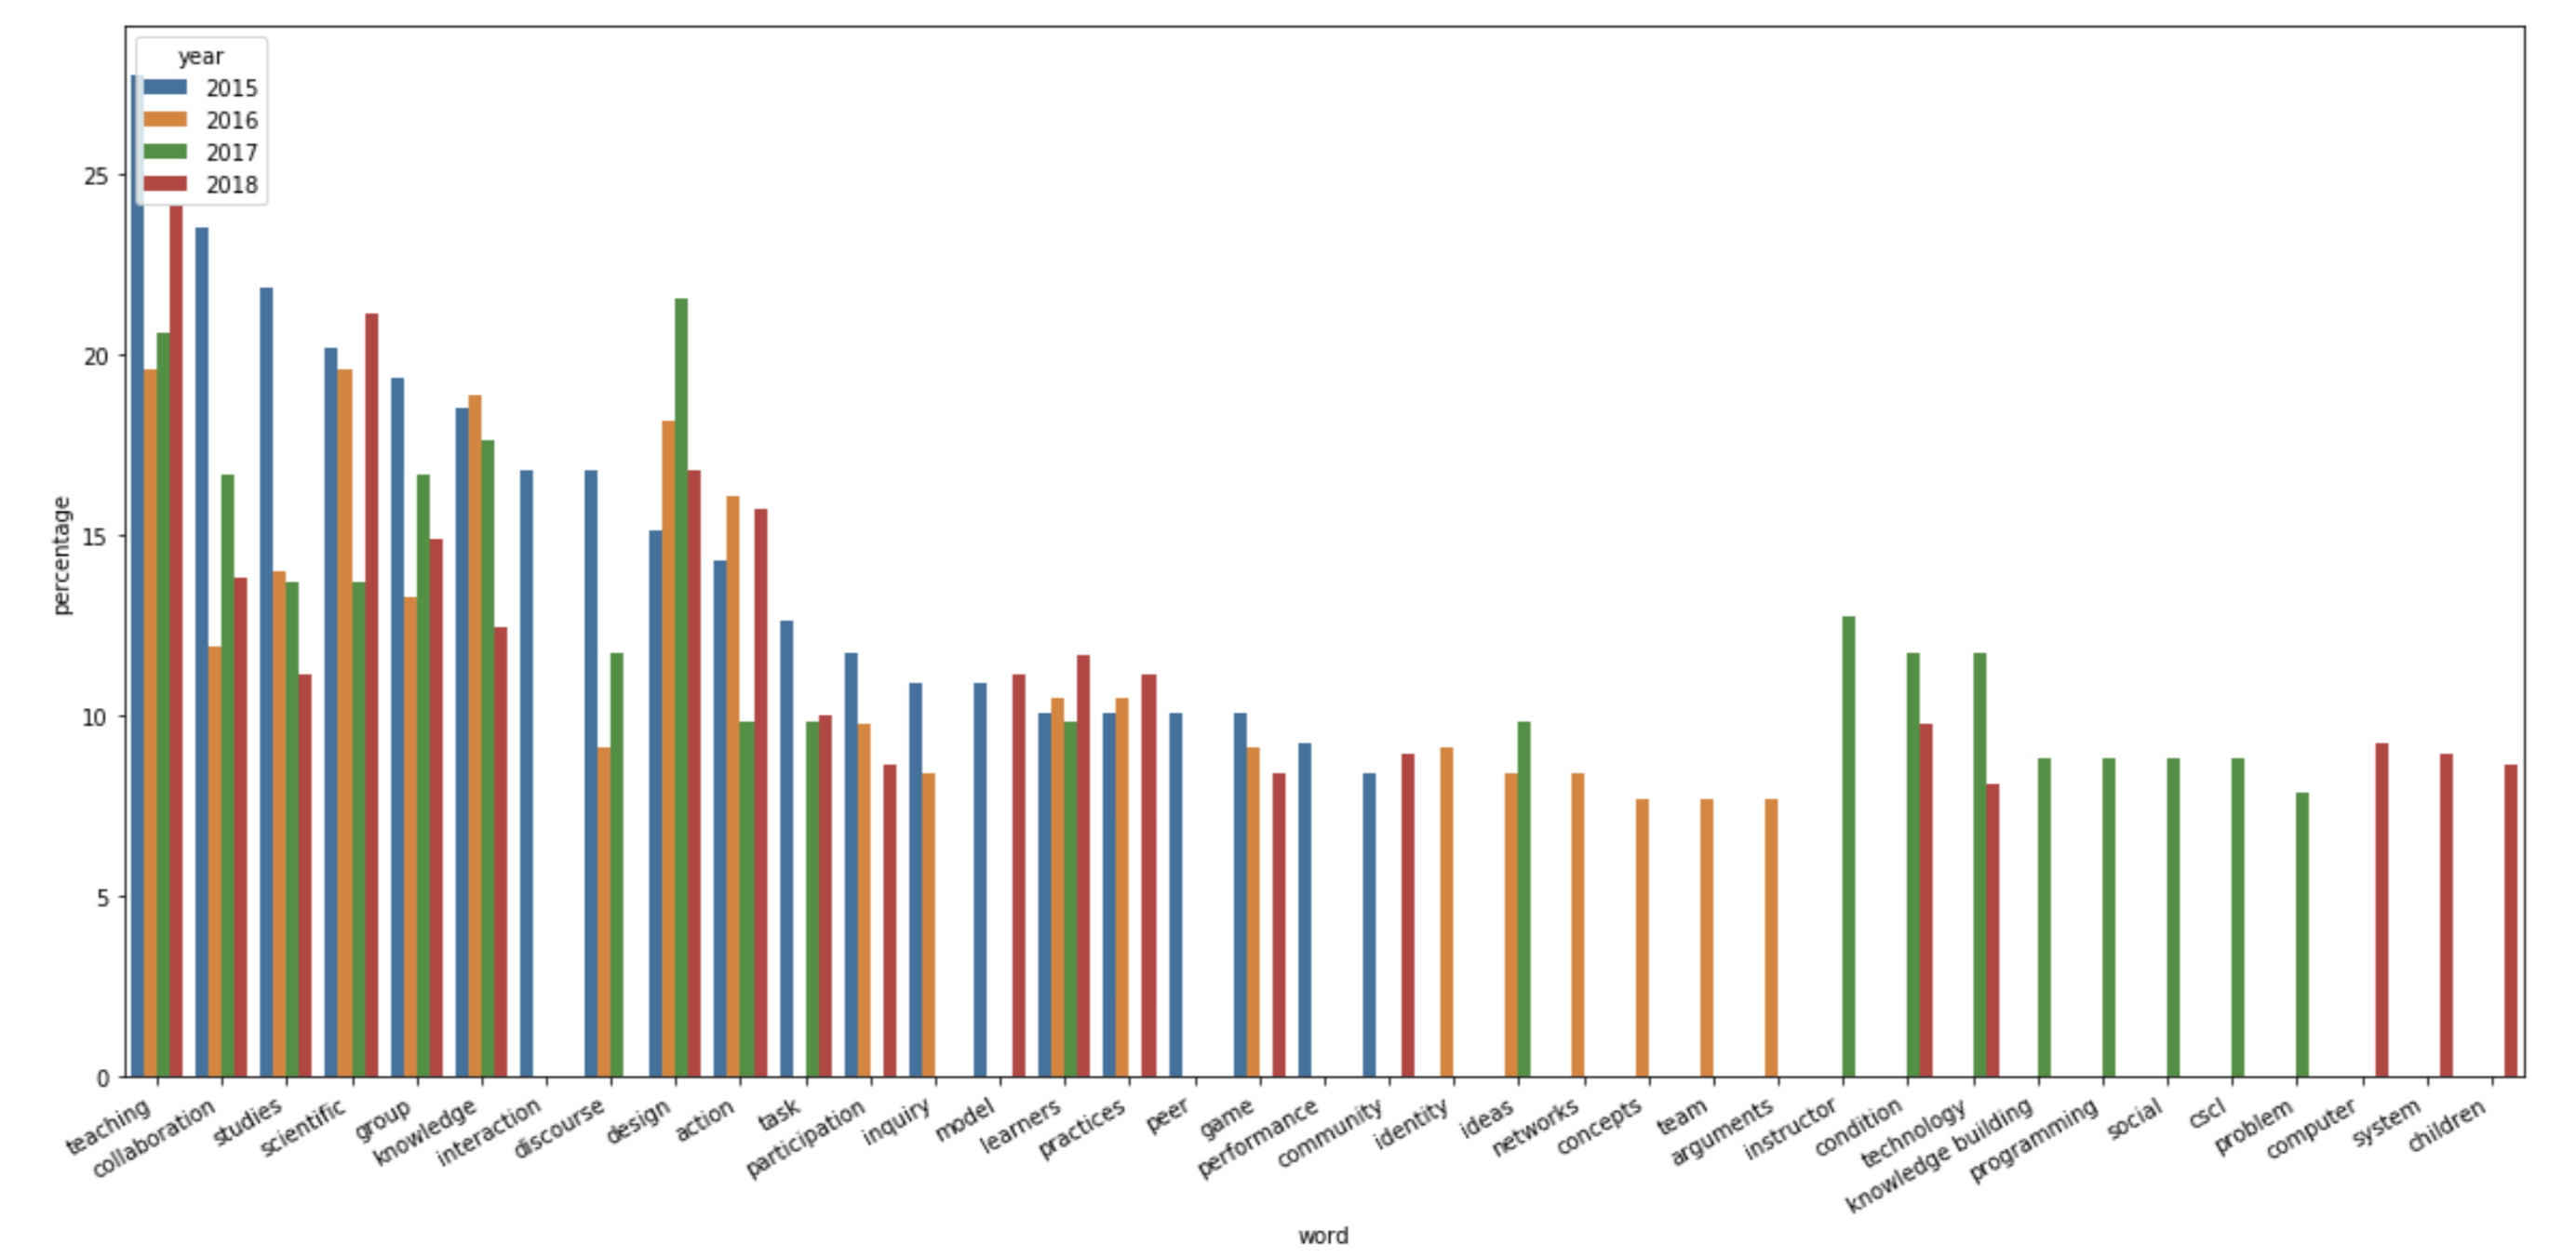

In [27]:
from IPython.display import Image, display
display(Image("../keywords_by_year.png"))

We wanted then to know what are the trends of words for each specific year, so we selected distinct words for each year, it means that we selected for each year the words that were present for that year and never for the others.
We get the graph below. 
As we can see from the graph, the most used word in the papers, more than 10% of 2015 papers uses the word 'peer', more than 6% of the papers uses the words 'building', 'embodied' in 2016. In 2017 the most frequent keyword on is 'reponsive' and in 2018 'tools' is present with more than 6%.  

# Methodology [find better section head..]

## Document Clustering 


## Co-authorship graphs
## Interactive Map visualizations


# Results

## Community Composition & Structure

We find that participants from 372 institutions participated over the last 4 years, with a median of 128 institutions per year. Numbers of institutions participating are increasing each year, with a noticeable peak in 2018, which participants from 261 institutions. This is a considerable up from the last conference ICLS in 2016 which had 135 participating institutions. 
Most participants are from the US, with a average of 50% of all participants being from the US. We can also observe a trend of increase in US participants with only 35% of US participants in 2015 and 51% in 2017, followed by 64% in 2018. Overall, participants from 41 nations have participated over the 4 years, which an average of 28 nations represented each conference. After the US, participants of Germany, Canada and Singapore make up the biggest proportion of participants $\ref{figrep}$.


    1. Collaboration
    2. Movement of participants
    3. Citation

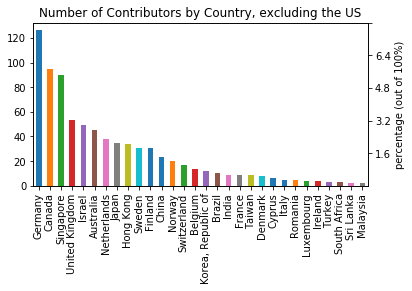

In [22]:
import numpy as np
universities = pd.read_pickle('../data/Universities.pkl')
universities.rename(columns={'email': 'mail'}, inplace=True)

percentages = (100*universities[
    (~universities.mail.duplicated()) 
    & (universities.country !='United States')].country.value_counts() /
    universities[(~universities.mail.duplicated())]
    .country.value_counts().sum()).tolist()

percentages[0], percentages[-1]


fig, ax1 = plt.subplots(figsize=(6, 3))
universities[(~universities.mail.duplicated()) & 
             (universities.country !='United States')].country.value_counts().head(30).plot(kind = 'bar')


ax2 = ax1.twinx()
ax2.set_yticks(range(5, 0, -1))
ax2.set_yticklabels(['']+[ str(i)[:3] for i in np.linspace(percentages[0], percentages[-1], num=5)])
ax2.set_ylabel('percentage (out of 100%)')
plt.yticks()

plt.title('Number of Contributors by Country, excluding the US') # as determinded by university affiliation
plt.show()

### Collaboration




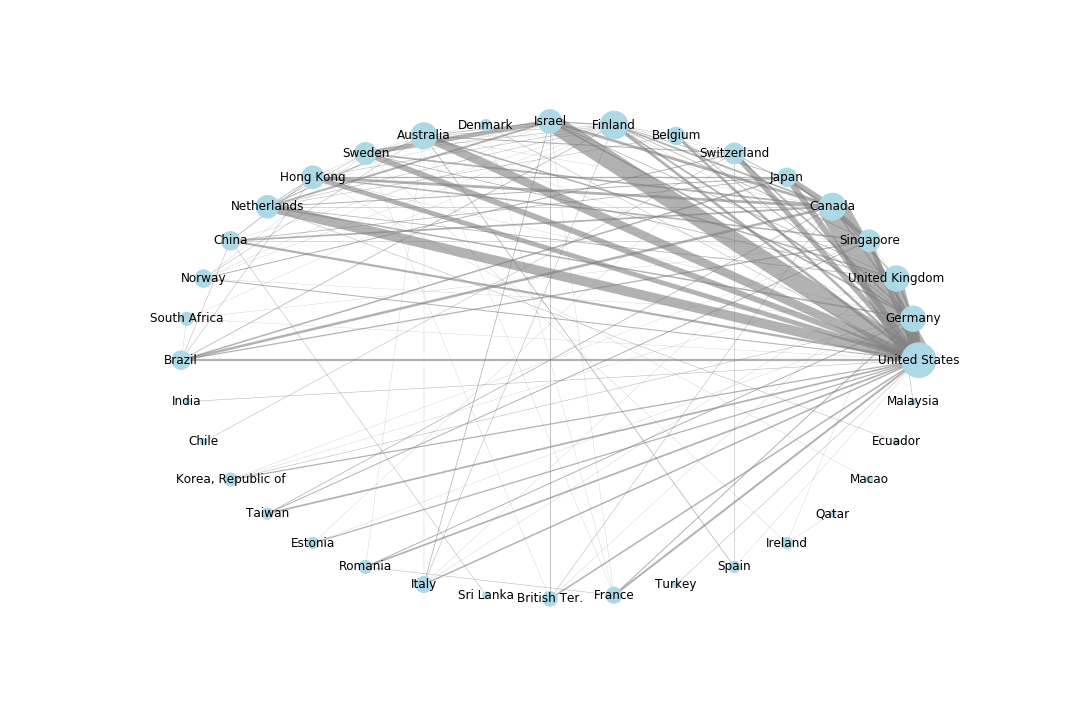

In [26]:
display(Image('../figures/country_collab.png'))

## Research topics in the Community
    1. Keywords
    2. Outside influence: Conferences being sited

# Illustrative Example

For the purposes of illustration, consider a damped harmonic oscillator driven by a sinusoidal signal:
\begin{equation}
\frac{\mathrm{d}^2x}{\mathrm{d}t^2} + 2\zeta\omega_0\frac{\mathrm{d}x}{\mathrm{d}t} + \omega_0^2x = A\sin(\omega t), \label{eq:problem}
\end{equation}
\noindent where $x(t)$ is the quantity of interest, $\zeta$ is the damping constant, $\omega_0$ is the undamped resonant frequency, and $A\sin(\omega t)$ is the driving sinusoidal signal. The steady state solution to \eqref{eq:problem} is given by:
\begin{eqnarray}
x(t) &=& \frac{A}{Z_m\omega}\sin(\omega t + \phi), \label{eq:soln}\\
Z_m &=& \sqrt{(2\omega_0\zeta)^2+\frac{(\omega^2-\omega_0^2)^2}{\omega^2}}, \nonumber\\
\phi &=& \arctan\left(\frac{2\omega\omega_0\zeta}{\omega^2-\omega_0^2}\right). \nonumber
\end{eqnarray}

In [8]:
import numpy as np
import arlpy.plot as plt

In [9]:
# set plotting to generate static images that can be included in pdfs

plt.use_static_images()
plt.figsize(500, 400)

In [10]:
# Z_m computed as per equation \eqref{eq:soln} above

def Zm(w, w0, z):
    return np.sqrt((2*w0*z)**2 + ((w**2-w0**2)**2)/w**2)

In [11]:
# parameters to show plot for

f0 = 100                       # undamped resonant frequency (Hz)
A = 1e6                        # driving amplitude

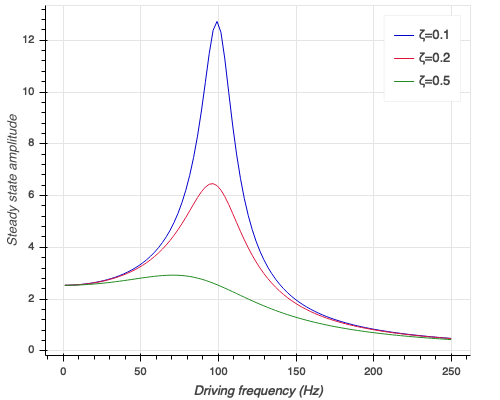

In [12]:
# the caption and label of this figure are in the metadata of this cell
# you can edit it using "View > Cell Toolbar > Edit Metadata"

f = np.linspace(1, 250, 100)
w0 = 2*np.pi*f0
w = 2*np.pi*f
plt.figure(xlabel='Driving frequency (Hz)', ylabel='Steady state amplitude', )
plt.plot(f, A/Zm(w, w0, 0.1)/w, legend='ζ=0.1', hold=True)
plt.plot(f, A/Zm(w, w0, 0.2)/w, legend='ζ=0.2', hold=True)
plt.plot(f, A/Zm(w, w0, 0.5)/w, legend='ζ=0.5')

In Figure \ref{fig1} we plot the steady state amplitude of a 100 Hz oscillator as a function of driving frequency. We see that the oscillator exhibits a strong resonance for small values of $\zeta$, and that the resonance frequency is slightly lower than the driving frequency of 100 Hz.

In [13]:
# sample algorithm (nothing meaningful in the algorithm here!)

# Conclusions

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.